<a href="https://colab.research.google.com/github/enino84/Data-Assimilation-2022/blob/main/DA_Sampling_Errors_and_Localization_Methods_LEnKF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Assimilation - Sampling Errors and Localization Methods**

\begin{eqnarray}
\frac{dx_i}{dt} = (x_{i+1}-x_{i-2})x_{i-1} - x_i + F
\end{eqnarray}

When $F=8$, the model exhibit chaotic behavior

In [ ]:
import numpy as np
import seaborn as sns
import scipy as sci
from scipy.integrate import odeint
import matplotlib.pyplot as plt


In [ ]:
def lorenz96(x, t, args=(8,)):
  n = x.size;
  F = args[0];
  return [(x[(i+1)%n]-x[i-2])*x[i-1]-x[i]+F for i in range(0,n)]; #list comprehension

In [ ]:
def forecast(x, t):
  return odeint(lorenz96, x, t)[-1,:];

In [ ]:
def create_initial_ensemble(xb, t, N):
  Xb = [];
  for e in range(0,N):
    xbe_pert = xb+0.01*np.random.randn(n); #e-th pertured ensemble member (no consistent with model dynamics)
    xbe = forecast(xbe_pert, t); #e-th ensemble member (consistent with model dynamics)
    Xb.append(xbe);
  return Xb;

In [ ]:
def forecast_ensemble(Xb, t, N):
  for e,xbe in enumerate(Xb):
    Xb[e,:] = forecast(Xb[e,:], t);
  return Xb;

Create initial settings 

1. The initial condition
2. Initial background
3. Initial background ensemble

In [ ]:
#Create initial condition

n = 40; #40 variables
x_random = np.random.randn(n); #pertured random state (no consistent with model dynamics)
t = np.linspace(0,10, 50);
x0 = forecast(x_random, t); #initial condition (consistent with model dynamics)

xt = forecast(x0, t); #reference solution
xb = forecast(x0+0.01*np.random.randn(n), t); #background state (about this state we'll build the initial ensemble)

N = 100;
Xb0 = create_initial_ensemble(xb, t, N);
xt0 = forecast(x0, t);

# Ensemble inicial ${\bf X}^b_0$

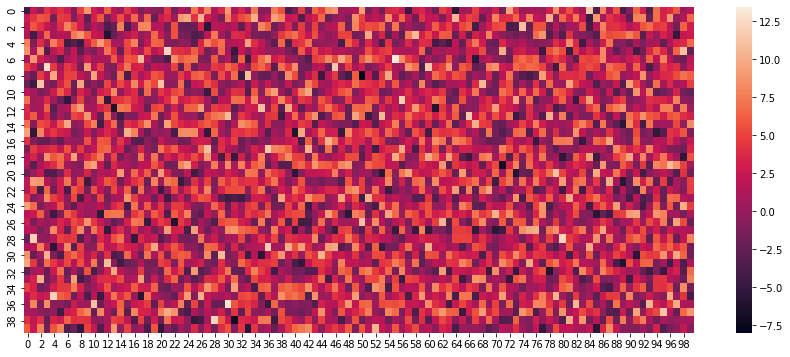

In [ ]:
plt.figure(figsize=(15,6))
sns.heatmap(np.array(Xb0).T)

# Full assimilation cycle

# ${\bf X}^a = {\bf X}^b + {\bf P}^b {\bf H}^T \underbrace{\left ( {\bf R}+{\bf H}{\bf P}^b {\bf H}^T \right )^{-1} \underbrace{\left[{\bf Y}^s-{\bf H}{\bf X}^b \right ]}_{{\bf D}}}_{{\bf Z}} = {\bf X}^b + {\bf P}^b {\bf H}^T {\bf Z}$

1. ${\bf y} \sim \mathcal{N}({\bf H}{\bf x}^{*},\, {\bf R})$

In [ ]:
p = 0.8; #[0, 1] 0: no observations and 1: full observational network
m = round(p*n); #number of observations m<=n
err_obs = 0.01; #standard deviations of errors (a typical value)
R = (err_obs**2)*np.eye(m, m); #covariance matrix of data errors
M = 20; #number of assimilation cycles
t = [0, 0.1]; #16 hours ~ 8 hours (in practice)
N = 20;

In [ ]:
np.random.permutation(np.arange(n))[:m]

array([24, 31,  1,  8, 13, 29,  3, 19,  4, 32, 37, 30, 22, 38,  9,  0, 17,
       18,  2,  6,  7, 15, 20, 14, 36, 10, 35, 33, 16, 26, 28,  5])

In [ ]:
xt = np.array(xt0).astype('float32');
Xa = np.array(Xb0.copy()).astype('float32')[:N,:];

err_a = [];
err_b = [];

for k in range(M):
  #Forecast step
  xt = forecast(xt, t);
  Xb = forecast_ensemble(Xa, t, N);
  Pb = np.cov(Xb.T);
  xb = np.mean(Xb, axis=0);
  err_b.append(np.linalg.norm(xb-xt));
 
  #Create observation - data for the assimilation process
  H = np.random.permutation(np.arange(n))[:m]; #we observe a different part of the domain
  y = np.random.multivariate_normal(xt[H], R);

  #Assimilation step
  Ys = np.random.multivariate_normal(y, R, N).T; #synthetic observations
  Ds = Ys - Xb[:,H].T; #Synthetic innovations
  Pa = R + Pb[H,:][:,H]; #Pa = R + H @ Pb @ H.T
  Za = np.linalg.solve(Pa, Ds);
  DX = Pb[:,H] @ Za;
  Xa = Xb + DX.T;
  xa = np.mean(Xa, axis=0);
  err_a.append(np.linalg.norm(xa-xt));

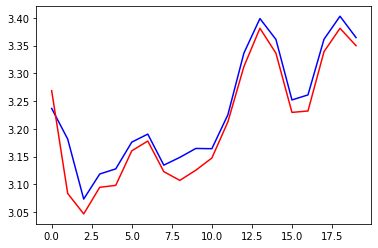

In [ ]:
plt.plot(np.log(np.array(err_b)), '-b')
plt.plot(np.log(np.array(err_a)), '-r')

Error $N=100$:

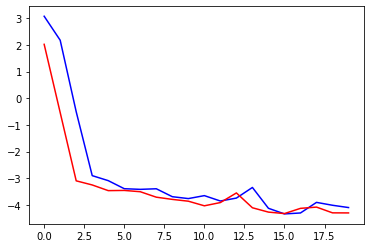

Error $N=40$

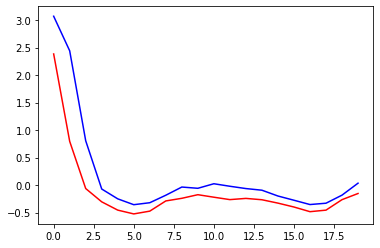

Error $N=20$

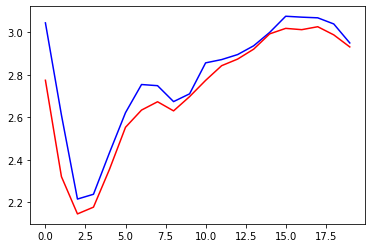

# **Covariance matrix**

In [ ]:
N=20;
xt = np.array(xt0).astype('float32');
Xb = np.array(Xb0.copy()).astype('float32')[:N,:];
Pb = np.cov(Xb.T);

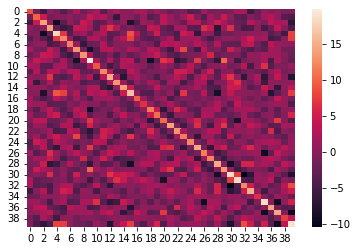

In [ ]:
sns.heatmap(Pb)

${\bf P}^b$ for $N=100$

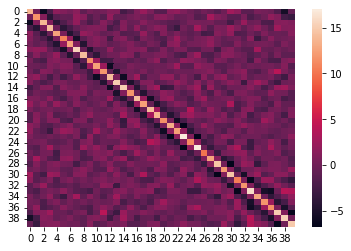

${\bf P}^b$ for $N=40$

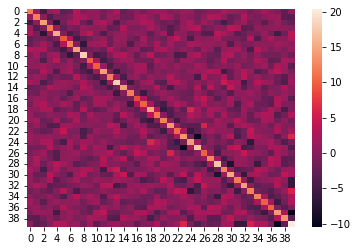

${\bf P}^b$ for $N=20$

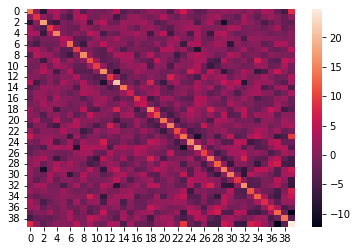

# **Localization**

1. Decorrelation matrix - $\delta$ radius of influence
2. Gaussian model

\begin{eqnarray}
{\bf L}_{i,j} = \exp \left (-\frac{1}{2} \frac{d_{i,j}^2}{\delta^2} \right )
\end{eqnarray}




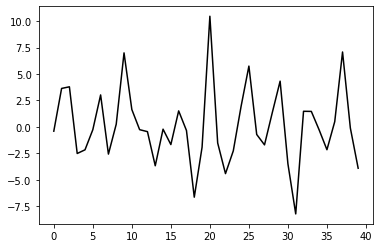

In [ ]:
plt.plot(Pb[20,:],'-k')

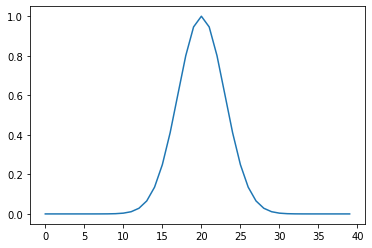

In [ ]:
plt.plot(np.exp(-.5*np.power(np.arange(40)-20,2)/(3**2)))

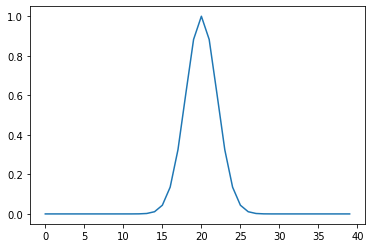

In [ ]:
plt.plot(np.exp(-.5*np.power(np.arange(40)-20,2)/(2**2)))

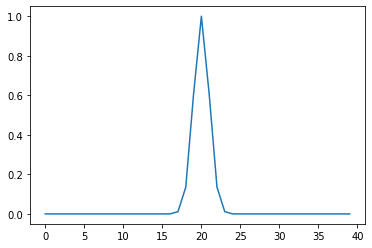

In [ ]:
plt.plot(np.exp(-.5*np.power(np.arange(40)-20,2)/(1**2)))

The decorrelation matrix looks as follows:

In [ ]:
def decorrelation_matrix(n, r):
  L = np.zeros((n,n));
  for i in range(n):
    for j in range(n):
      dij = min(np.mod(j-i, n), np.mod(i-j, n));
      L[i, j] = np.exp(-0.5*(dij**2)/r**2);
  return L;

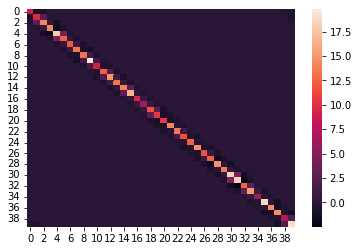

In [ ]:
r = 1;
L1 = decorrelation_matrix(n, r);
sns.heatmap(L1*Pb)

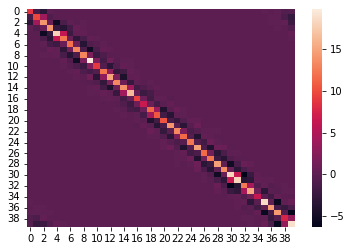

In [ ]:
r = 2;
L2 = decorrelation_matrix(n, r);
sns.heatmap(L2*Pb)

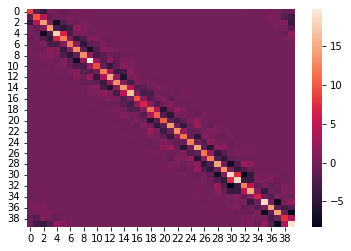

In [ ]:
r = 3;
L3 = decorrelation_matrix(n, r);
sns.heatmap(L3*Pb)

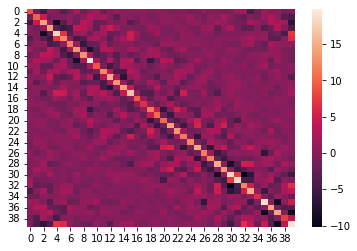

In [ ]:
r = 10;
L10 = decorrelation_matrix(n, r);
sns.heatmap(L10*Pb)

# **Full assimilation cycle with localization**

The decorrelation matrix looks as follows:

```python
def decorrelation_matrix(n, r):
  L = np.zeros((n,n));
  for i in range(n):
    for j in range(n):
      dij = min(np.mod(j-i, n), np.mod(i-j, n));
      L[i, j] = np.exp(-0.5*(dij**2)/r**2);
  return L;
```

# ${\bf X}^a = {\bf X}^b + ({\bf L}\circ{\bf P}^b) {\bf H}^T \left ( {\bf R}+{\bf H}({\bf L}\circ{\bf P}^b) {\bf H}^T \right )^{-1} \left[{\bf Y}^s-{\bf H}{\bf X}^b \right ] $

In [ ]:
def decorrelation_matrix(n, r):
  L = np.zeros((n,n));
  for i in range(n):
    for j in range(n):
      dij = min(np.mod(j-i, n), np.mod(i-j, n));
      L[i, j] = np.exp(-0.5*(dij**2)/r**2);
  return L;

In [ ]:
p = 0.8; #[0, 1] 0: no observations and 1: full observational network
m = round(p*n); #number of observations m<=n
err_obs = 0.01; #standard deviations of errors (a typical value)
R = (err_obs**2)*np.eye(m, m); #covariance matrix of data errors
M = 20; #number of assimilation cycles
t = [0, 0.1];
N = 20;
r = 1; #Radius of influence

In [ ]:
xt = np.array(xt0).astype('float32');
Xa = np.array(Xb0.copy()).astype('float32')[:N,:];

L = decorrelation_matrix(n, r);

err_a = [];
err_b = [];

for k in range(M):
  #Forecast step
  xt = forecast(xt, t);
  Xb = forecast_ensemble(Xa, t, N);
  Pb = L * np.cov(Xb.T); #localized background error covariance matrix
  xb = np.mean(Xb, axis=0);
  err_b.append(np.linalg.norm(xb-xt));
 
  #Create observation - data for the assimilation process
  H = np.random.permutation(np.arange(n))[:m]; #we observe a different part of the domain
  y = np.random.multivariate_normal(xt[H], R);

  #Assimilation step
  Ys = np.random.multivariate_normal(y, R, N).T; #synthetic observations
  Ds = Ys - Xb[:,H].T; #Synthetic innovations
  Pa = R + Pb[H,:][:,H]; #Pa = R + H @ Pb @ H.T
  Za = np.linalg.solve(Pa, Ds);
  DX = Pb[:,H] @ Za;
  Xa = Xb + DX.T;
  xa = np.mean(Xa, axis=0);
  err_a.append(np.linalg.norm(xa-xt));

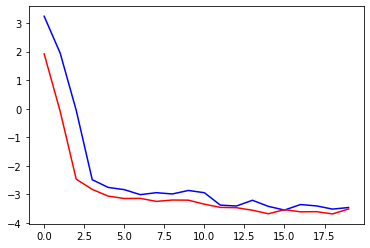

In [ ]:
plt.plot(np.log(np.array(err_b)), '-b')
plt.plot(np.log(np.array(err_a)), '-r')

# **Local Analysis**

In [ ]:
p = 0.8; #[0, 1] 0: no observations and 1: full observational network
m = round(p*n); #number of observations m<=n
err_obs = 0.01; #standard deviations of errors (a typical value)
R = (err_obs**2)*np.eye(m, m); #covariance matrix of data errors
M = 20; #number of assimilation cycles
t = [0, 0.1];
N = 20;
r = 1; #Radius of influence
ind = np.arange(0, n)

# **Local ensemble Kalman filter (LEnKF)**

# ${\bf X}_i^a = {\bf X}_i^b + {\bf P}_i^b {\bf H}_i^T \underbrace{\left ( {\bf R}_i+{\bf H}_i{\bf P}_i^b {\bf H}_i^T \right )^{-1} \underbrace{\left[{\bf Y}_i^s-{\bf H}_i{\bf X}_i^b \right ]}_{{\bf D}_i}}_{{\bf Z}_i} = {\bf X}_i^b + {\bf P}_i^b {\bf H}_i^T {\bf Z}_i$.

In [ ]:
def local_analysis_LEnKF(Xb, H, R, y, N, i, r):
  #Subdomain decomposition
  si = [(i+j)%n for j in range(-r,r+1)]
  Xbi = Xb[:, si]
  Pbi = np.cov(Xbi.T)

  #Observations
  oi = np.array([s_i for s_i in si if s_i in H]); #Global index
  Hi = np.array([i for i,s_i in enumerate(si) if s_i in H]); #Local indexes
  mi = len(Hi); #Number of local observations

  if mi>0:
    yi = yz[oi]; #We take the local observations from the model state
    Ri = (err_obs**2)*np.eye(mi, mi); #Local error covariance matrix
    Ysi = np.random.multivariate_normal(yi, Ri, N); #Synthetic observations
    Di = Ysi - Xbi[:, Hi]; #Innovation matrix (local)

    #Local Assimilation
    Pai = Ri + Pbi[Hi,:][:,Hi]; #Pa = R + H @ Pb @ H.T
    Zai = np.linalg.solve(Pai, Di.T);
    DXi = Pbi[:,Hi] @ Zai;
    Xai = Xbi + DXi.T;
  else:
    Xai = Xbi;

  return Xai;

In [ ]:
np.random.seed(10)
xt = np.array(xt0).astype('float32');

err_a = [];
err_b = [];

Xa = np.array(Xb0.copy()).astype('float32')[:N,:];

r = 1;

for k in range(0, M):
  
  xt = forecast(xt, t);
  Xb = forecast_ensemble(Xa, t, N);
  #Create observation - data for the assimilation process
  H = np.random.permutation(np.arange(n))[:m]; #we observe a different part of the domain
  H.sort()

  #Synthetic observation to test our method
  y = np.random.multivariate_normal(xt[H], R);
  yz = np.zeros((n,))

  #We project back onto the model space (to make easier the indexation)
  yz[H] = y

  Xa = np.zeros((N,n)); #Local analysis for each model component i
  for i in range(0, n):
    Xai = local_analysis_LEnKF(Xb, H, R, y, N, i, r)
    Xa[:, i] = Xai[:, r]; #

  xb = np.mean(Xb, axis=0);
  err_b.append(np.linalg.norm(xb-xt));
  xa = np.mean(Xa, axis=0);
  err_a.append(np.linalg.norm(xa-xt));

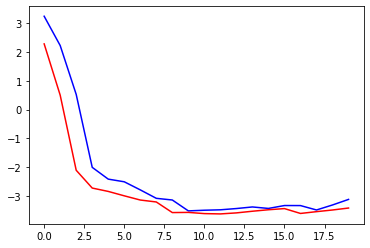

In [ ]:
plt.plot(np.log(np.array(err_b)), '-b')
plt.plot(np.log(np.array(err_a)), '-r')

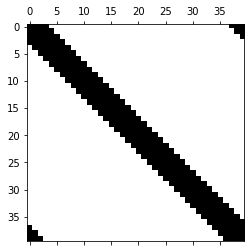

In [ ]:
r = 3
M = np.zeros((n,n))
for i in range(0, n):
  si = [(i+j)%n for j in range(-r,r+1)]
  M[i,si] = 1;
plt.spy(M)